In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Matplotlib is building the font cache; this may take a moment.


## Creat and connect to an MLFlow Client

In [2]:
client = mlflow.MlflowClient(tracking_uri="http://localhost:8080")

## Search Experiments with the MLflow Client 
Let's take a look at the Default Experiment that is created for us.

This safe 'fallback' experiment will store Runs that we create if we don't specify a 
new experiment. 

In [3]:
# Search experiments without providing query terms behaves effectively as a 'list' action

all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='file:///c:/Users/endie/Documents/codes/Data_work/ML-AI/ML_projects/mlruns/944059796455378175', creation_time=1752217610862, experiment_id='944059796455378175', last_update_time=1752217610862, lifecycle_stage='active', name='Unicorn Model', tags={'version': '1.0'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1752215616171, experiment_id='0', last_update_time=1752215616171, lifecycle_stage='active', name='Default', tags={}>]


## Creat a new experiment for the Predicting London Mean Temperature Project

- create a new MLflow Experiment
- apply metadata in the form of Experiment Tags

## Project Objective
Run a lot of experiments to determine what the best approach is to predict London weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of

In [6]:
from datetime import datetime

experiment_description = (
    "This is an experiment to predict the mean temperature in London using various regression models. "
    "This experiment will explore different feature sets, model configurations, and evaluation metrics to find the best approach for accurate temperature prediction."
)

experiment_tags = {
    "project_name": "London-mean-temperature-prediction",
    "project_objective": "Run experiments to determine the best regression model for predicting London mean temperature.",
    "mlflow-note-author": "Endie",
    "mlflow-note-date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "mlflow.note.content": experiment_description,
}

london_mean_temp = client.create_experiment(name="mean_temp_model", tags=experiment_tags)

In [18]:
print(f"Experiment created with ID: {london_mean_temp}")

Experiment created with ID: 212837754345050595


In [7]:
# Use search_experiments() to search on the project_name tag key
from pprint import pprint

weather_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'London-mean-temperature-prediction'"
)

pprint(weather_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/212837754345050595', creation_time=1753326353735, experiment_id='212837754345050595', last_update_time=1753326353735, lifecycle_stage='active', name='mean_temp_model', tags={'mlflow-note-author': 'Endie',
 'mlflow-note-date': '2025-07-23 23:05:53',
 'mlflow.note.content': 'This is an experiment to predict the mean temperature '
                        'in London using various regression models. This '
                        'experiment will explore different feature sets, model '
                        'configurations, and evaluation metrics to find the '
                        'best approach for accurate temperature prediction.',
 'project_name': 'London-mean-temperature-prediction',
 'project_objective': 'Run experiments to determine the best regression model '
                      'for predicting London mean temperature.'}>


### Running our first model training

In this section, we'll:

* import the London weather data set that is relevant to a mean temperature forecasting task
* start an MLflow run
* log metrics, parameters, and tags to the run
* save the model to the run
* register the model during model logging

In [9]:
london_temp_df = pd.read_csv("london_weather.csv")
london_temp_df.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [10]:
london_temp_df.head(10)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
5,19790106,5.0,3.8,39.0,8.3,-0.5,-6.6,0.7,102780.0,1.0
6,19790107,8.0,0.0,13.0,8.5,1.5,-5.3,5.2,102520.0,0.0
7,19790108,8.0,0.1,15.0,5.8,6.9,5.3,0.8,101870.0,0.0
8,19790109,4.0,5.8,50.0,5.2,3.7,1.6,7.2,101170.0,0.0
9,19790110,7.0,1.9,30.0,4.9,3.3,1.4,2.1,98700.0,0.0


In [11]:
# Convert date to datetime
london_temp_df['date'] = pd.to_datetime(london_temp_df['date'], format='%Y%m%d')

# Extract temporal features
london_temp_df['month'] = london_temp_df['date'].dt.month
london_temp_df['dayofyear'] = london_temp_df['date'].dt.dayofyear
# london_temp_df['weekday'] = london_temp_df['date'].dt.weekday  # Optional

# Drop original date column if not using it directly
london_temp_df.drop(columns=['date'], inplace=True)

london_temp_df.head(10)


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,dayofyear
0,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1
1,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1,2
2,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1,3
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1,4
4,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1,5
5,5.0,3.8,39.0,8.3,-0.5,-6.6,0.7,102780.0,1.0,1,6
6,8.0,0.0,13.0,8.5,1.5,-5.3,5.2,102520.0,0.0,1,7
7,8.0,0.1,15.0,5.8,6.9,5.3,0.8,101870.0,0.0,1,8
8,4.0,5.8,50.0,5.2,3.7,1.6,7.2,101170.0,0.0,1,9
9,7.0,1.9,30.0,4.9,3.3,1.4,2.1,98700.0,0.0,1,10


In [12]:
london_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       15322 non-null  float64
 1   sunshine          15341 non-null  float64
 2   global_radiation  15322 non-null  float64
 3   max_temp          15335 non-null  float64
 4   mean_temp         15305 non-null  float64
 5   min_temp          15339 non-null  float64
 6   precipitation     15335 non-null  float64
 7   pressure          15337 non-null  float64
 8   snow_depth        13900 non-null  float64
 9   month             15341 non-null  int32  
 10  dayofyear         15341 non-null  int32  
dtypes: float64(9), int32(2)
memory usage: 1.2 MB


In [13]:
#Check for missing values
london_temp_df.isnull().sum()


cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
month                  0
dayofyear              0
dtype: int64

## Drop rows where target is missing

In [14]:
# Drop rows where target is missing
london_temp_df = london_temp_df.dropna(subset=['mean_temp'])

# Check for missing values again
london_temp_df.isnull().sum()

cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp              0
min_temp               0
precipitation          2
pressure               4
snow_depth          1424
month                  0
dayofyear              0
dtype: int64

## How to treat other columns with missing values

Seeing that we now only have three columns with missing(cloud_cover, global_radiation, and snow_depth) values less than 10% of the entire dataset, we could decide to treat as:
- Drop all rows with missing values
- Replace with either median 

### Drop all rows with missing values

In [15]:
london_temp_df.dropna(inplace=True)  # Drop rows with missing values

london_temp_df.isnull().sum()

cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
month               0
dayofyear           0
dtype: int64

In [16]:
london_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13843 entries, 0 to 14974
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       13843 non-null  float64
 1   sunshine          13843 non-null  float64
 2   global_radiation  13843 non-null  float64
 3   max_temp          13843 non-null  float64
 4   mean_temp         13843 non-null  float64
 5   min_temp          13843 non-null  float64
 6   precipitation     13843 non-null  float64
 7   pressure          13843 non-null  float64
 8   snow_depth        13843 non-null  float64
 9   month             13843 non-null  int32  
 10  dayofyear         13843 non-null  int32  
dtypes: float64(9), int32(2)
memory usage: 1.2 MB


## Visualize data Corelation relationship

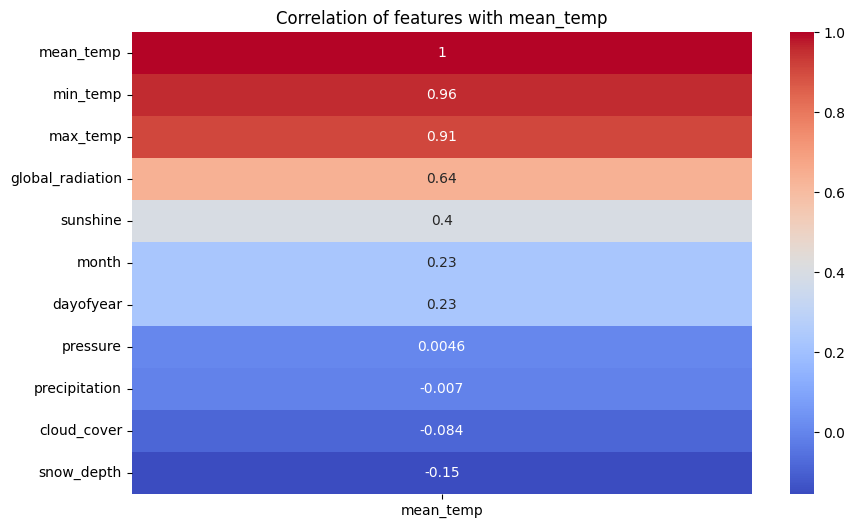

In [17]:
corr_matrix = london_temp_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['mean_temp']].sort_values(by='mean_temp', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Correlation of features with mean_temp")
plt.show()

## PRocessing and Splitting Data

In [19]:
# Final feature list based on correlation
final_features = [
    'min_temp', 'max_temp',
    'global_radiation', 'sunshine',
    'month', 'dayofyear'
]

def prepare_data(df, target='mean_temp'):
    X = df[final_features]
    y = df[target]
    return train_test_split(X, y, test_size=0.2, shuffle=False)  # time-aware split

## Define Train & Log Function

In [28]:
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
mlflow.set_tracking_uri("http://localhost:8080")
def train_and_log_model(model_name, model, X_train, X_test, y_train, y_test, use_scaler=False):
    with mlflow.start_run(experiment_id=london_mean_temp, run_name=model_name):
        # Conditionally apply scaling
        if use_scaler:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
        else:
            pipeline = Pipeline([
                ('model', model)
            ])
        
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)

        # Log model params
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("features", ",".join(final_features))
        mlflow.log_param("scaling", use_scaler)

        # Log metrics
        rmse =root_mean_squared_error(y_test, preds)
        
        mlflow.log_metric("rmse", rmse)
        

        # Log full pipeline
        mlflow.sklearn.log_model(pipeline, "model")

        print(f"{model_name} -> RMSE: {rmse:.3f}")

## Run All Models


In [29]:
# Preprocess
X_train, X_test, y_train, y_test = prepare_data(london_temp_df.copy())

# Run experiments
train_and_log_model("LinearRegression", LinearRegression(), X_train, X_test, y_train, y_test, use_scaler=True)
train_and_log_model("RandomForest", RandomForestRegressor(n_estimators=100, max_depth=10), X_train, X_test, y_train, y_test)
train_and_log_model("DecisionTree", DecisionTreeRegressor(max_depth=10), X_train, X_test, y_train, y_test)


2025/07/24 01:47:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/24 01:47:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression -> RMSE: 0.938
🏃 View run LinearRegression at: http://localhost:8080/#/experiments/212837754345050595/runs/672326ea382e48b294e5d6c37ee2eb62
🧪 View experiment at: http://localhost:8080/#/experiments/212837754345050595


2025/07/24 01:47:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/24 01:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest -> RMSE: 0.925
🏃 View run RandomForest at: http://localhost:8080/#/experiments/212837754345050595/runs/fe65bed1159c46e7ad9443642440debe
🧪 View experiment at: http://localhost:8080/#/experiments/212837754345050595


2025/07/24 01:47:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/24 01:48:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTree -> RMSE: 1.056
🏃 View run DecisionTree at: http://localhost:8080/#/experiments/212837754345050595/runs/35d65ff64aad446cb00f671626cd7c17
🧪 View experiment at: http://localhost:8080/#/experiments/212837754345050595


## Set MLflow Goal
- RMSE ≤ 3

- All runs must log:

    + "rmse" as a named metric

    + Model type and hyperparameters

    + Feature set and scaling

## After All Runs — Retrieve Best Results

In [30]:

runs = client.search_runs(
    experiment_ids=[london_mean_temp],
    filter_string="metrics.rmse <= 3",
    order_by=["metrics.rmse ASC"]
)

# Store in experiment_results variable
experiment_results = pd.DataFrame([{
    "run_id": run.info.run_id,
    "model_type": run.data.params.get("model_type"),
    "rmse": run.data.metrics.get("rmse"),
    "r2": run.data.metrics.get("r2_score"),
    "scaling": run.data.params.get("scaling"),
    "features": run.data.params.get("features")
} for run in runs])

print("Filtered experiment results (RMSE ≤ 3):")
print(experiment_results)

Filtered experiment results (RMSE ≤ 3):
                             run_id        model_type      rmse    r2 scaling  \
0  fe65bed1159c46e7ad9443642440debe      RandomForest  0.924784  None   False   
1  672326ea382e48b294e5d6c37ee2eb62  LinearRegression  0.937767  None    True   
2  e5e6110ad13143a79782503e6f8c341b  LinearRegression  0.937767  None    True   
3  35d65ff64aad446cb00f671626cd7c17      DecisionTree  1.055668  None   False   

                                            features  
0  min_temp,max_temp,global_radiation,sunshine,mo...  
1  min_temp,max_temp,global_radiation,sunshine,mo...  
2  min_temp,max_temp,global_radiation,sunshine,mo...  
3  min_temp,max_temp,global_radiation,sunshine,mo...  
